In [44]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
import plotly.io as pio
pio.renderers.default = "svg"

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Import Quoilin dataset
Data available at: https://github.com/squoilin/Self-Consumption/releases Synthetic.Household.Profiles.h5

In [2]:
%%script false --no-raise-error
filename = "../../../pylec/studies/data/Synthetic.Household.Profiles.h5"
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    df = pd.read_hdf(filename, "TimeSeries")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    houseinfo = pd.read_hdf(filename, "HouseInfo")
mask = (houseinfo.Country == "France") & (houseinfo.Nmonths == "12")
df = df.loc[:, [str(a) for a in houseinfo[mask].pdIndex.tolist()]]

df["Index"] = pd.date_range(
    start="01-01-2019 00:00:00", end="31-12-2019 23:45:00", freq="15T"
)
df.set_index("Index", drop=True, inplace=True)

# --------------------------------------------
dateparse = lambda x: datetime.strptime(x, '%Y%m%d:%H%M')
pv = pd.read_csv("Timeseries_44.931_4.896_SA_1kWp_crystSi_14_38deg_-3deg_2014_2015.csv",
                 parse_dates=[0], index_col=[0], header=8, skipfooter=13, engine='python',
                 date_parser=dateparse)
# P is in W for a 1kW PV so we just have to change it to kW to get the coef 
pv = pv[['P']] / 1000
pv.columns = ["pv_1kw"]
pv = pv.loc['2014-01-01 00:00:00':'2015-01-01 00:10:00', :]

# Shifting things by 11 min, but whatever.
pv['Index'] = pd.date_range(start='2019-01-01 00:00:00',
                            end='2020-01-01 00:00:00', freq='60T')
pv.set_index('Index', drop=True, inplace=True)

# Interpolating to get 15-min interval values
pv = pv.resample('15T').interpolate('time')
pv.drop(pv.tail(1).index, inplace=True)

# --------------------------------------------
df["pv_1kw"] = pv["pv_1kw"]
df.to_pickle("fr_quoilin_data_valence.pickle")

In [13]:
df = pd.read_pickle("../2_chapter/fr_quoilin_data_valence.pickle")
df.head()

,2000900,2000901,2000903,2000904,2000905,2000906,2000907,2000908,2000909,2000910,...,2001188,2001189,2001190,2001192,2001193,2001194,2001195,2001197,2001199,pv_1kw
Index,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.295204,0.327625,0.483190,0.687899,0.143035,0.221557,0.224354,0.348925,2.359406,0.116382,...,0.079687,0.757643,0.080509,0.546715,0.026350,0.145583,0.160894,0.079701,1.420406,0.0
2019-01-01 00:15:00,0.223572,0.519240,0.236277,0.976978,0.178788,0.245871,0.485754,0.131845,1.064770,0.102974,...,0.269552,1.211409,0.074367,0.528931,0.057051,0.128810,0.155660,0.113194,0.641011,0.0
2019-01-01 00:30:00,0.237445,0.397812,0.151005,0.742844,0.232710,0.277901,0.594242,0.080997,0.897831,0.068910,...,0.107144,1.195561,0.083457,0.640498,0.069793,0.086199,0.188493,0.086067,0.540511,0.0
2019-01-01 00:45:00,0.477201,0.397999,0.398284,0.587097,0.285982,0.267720,0.512216,0.141001,1.433766,0.063750,...,0.165818,1.145802,0.107888,0.544124,0.060159,0.079745,0.160131,0.068022,0.863154,0.0
2019-01-01 01:00:00,0.415664,0.275134,0.108359,0.789470,0.181792,0.258787,0.185333,0.127379,1.140404,0.069257,...,0.250045,1.544101,0.036674,0.560161,0.031038,0.084432,0.178843,0.090153,0.814874,0.0


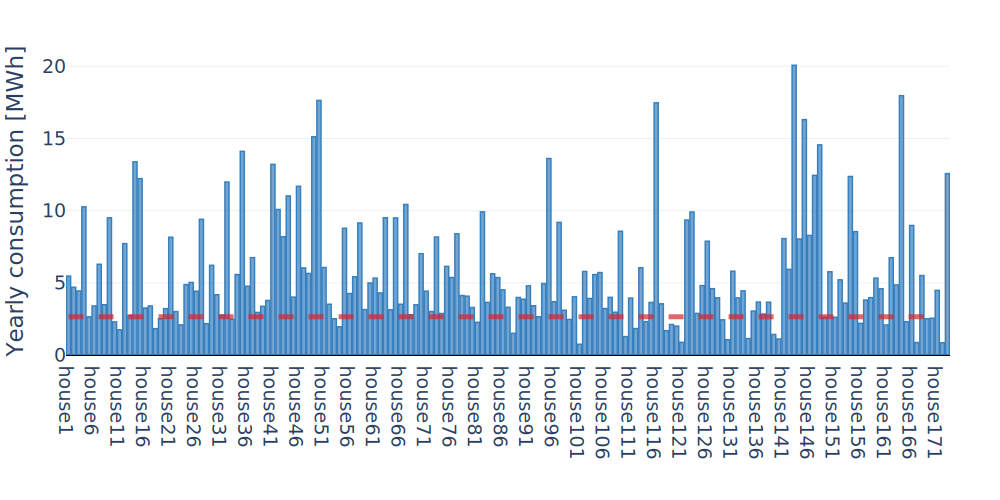

In [14]:
graph = df[[col for col in df.columns if "pv_1kw" not in col]].copy()
graph.columns = ["house" + str(n) for n in range(1, len(graph.columns) + 1)]
fig = px.bar(graph.sum() * 15 / 60 / 1000)
fig.data[0].update(
    {'marker': {'color': 'rgba(55, 128, 191, 0.7)',
                'line': {'width': 1.5,
                'color': 'rgba(55, 128, 191, 1.0)'}}})

# 'Reference for 100m2, 4 people, no elec. heating'
fig.add_shape(
  type='line',
  y0=2650/1000, y1=2650/1000, x0="house1", x1="house170",
  line={'dash': 'dash', 'width': 5,
        'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    width=1000,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Yearly consumption [MWh]")
fig.show()

# Set study on 20 households

In [15]:
nb_houses = 20

In [16]:
house_ids=[
    "2000989",
    "2001197",
    "2000914",
    "2001123",
    "2000964",
    "2001189",
    "2001111",
    "2001179",
    "2000909",
    "2000918",
    "2000994",
    "2001107",
    "2000913",
    "2001139",
    "2000960",
    "2001149",
    "2001165",
    "2000954",
    "2001114",
    "2000926",
]
df = df[house_ids + ["pv_1kw"]]
print(f"Average consumption is {round((df[house_ids].sum() * 15 / 60).mean() / 1000, 2)} MWh")
df.head()

Average consumption is 5.56 MWh


,2000989,2001197,2000914,2001123,2000964,2001189,2001111,2001179,2000909,2000918,...,2001107,2000913,2001139,2000960,2001149,2001165,2000954,2001114,2000926,pv_1kw
Index,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.420397,0.079701,0.857910,0.031886,0.181189,0.757643,0.190965,0.227143,2.359406,0.055817,...,0.070520,0.142502,0.255521,0.582962,0.180451,1.942729,3.863059,0.121460,0.469955,0.0
2019-01-01 00:15:00,0.545898,0.113194,1.250317,0.141971,0.137223,1.211409,0.093381,0.188724,1.064770,0.061609,...,0.088147,0.223753,0.345453,0.525038,0.200254,3.050416,5.486453,0.134062,0.684911,0.0
2019-01-01 00:30:00,0.434237,0.086067,1.391707,0.100812,0.145738,1.195561,0.059680,0.132277,0.897831,0.050262,...,0.114732,0.041090,0.326808,1.252299,0.226341,0.560178,4.171616,0.109371,0.762364,0.0
2019-01-01 00:45:00,0.282571,0.068022,1.058611,0.039150,0.292894,1.145802,0.157409,0.154381,1.433766,0.044647,...,0.140997,0.281691,0.546796,0.521619,0.218049,3.840278,3.296981,0.097153,0.579897,0.0
2019-01-01 01:00:00,0.269873,0.090153,0.930174,0.074543,0.215576,1.544101,0.051027,0.251023,1.140404,0.037189,...,0.085866,0.043304,0.188321,0.512975,0.145118,0.313930,4.377657,0.073465,0.317332,0.0


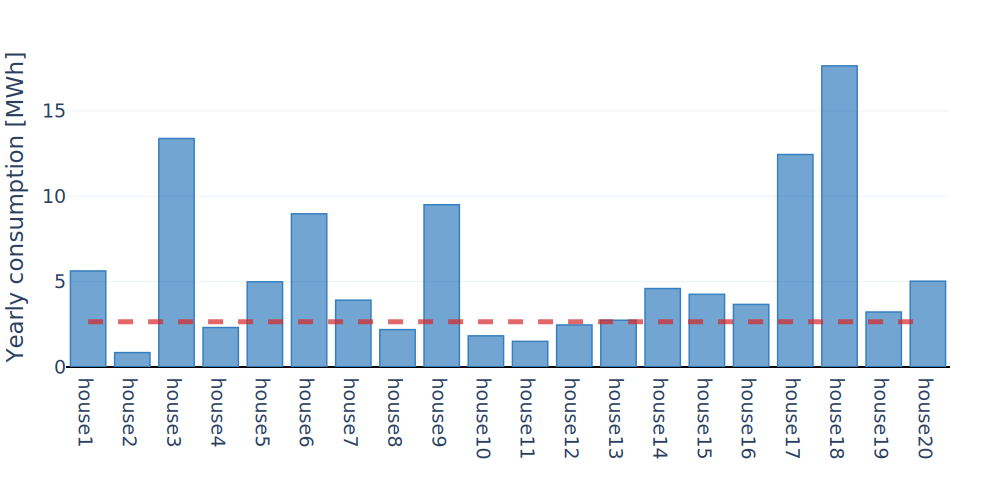

In [18]:
graph = df[[col for col in df.columns if "pv_1kw" not in col]].copy()
graph.columns = ["house" + str(n) for n in range(1, len(graph.columns) + 1)]
fig = px.bar(graph.sum() * 15 / 60 / 1000)
fig.data[0].update(
    {'marker': {'color': 'rgba(55, 128, 191, 0.7)',
                'line': {'width': 1.5,
                'color': 'rgba(55, 128, 191, 1.0)'}}})

# 'Reference for 100m2, 4 people, no elec. heating'
fig.add_shape(
  type='line',
  y0=2650/1000, y1=2650/1000, x0="house1", x1="house20",
  line={'dash': 'dash', 'width': 5,
        'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    width=1000,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Yearly consumption [MWh]")
fig.show()

In [19]:
df.describe().T[["mean", "min", "max"]]

,mean,min,max
2000989,0.642409,0.009760,15.452793
2001197,0.096313,0.002070,2.248960
2000914,1.527877,0.007914,73.415019
2001123,0.264018,0.010254,8.702582
2000964,0.569726,0.018387,17.223078
2001189,1.024281,0.014418,34.618334
2001111,0.446941,0.011408,9.133565
2001179,0.250011,0.008664,4.353821
2000909,1.084943,0.015853,23.098691
2000918,0.208345,0.004761,7.726401


In [20]:
individuals = df.copy()
df["community_kW"] = df[house_ids].sum(axis=1)
df.drop(house_ids, axis=1, inplace=True)

In [21]:
start = datetime(2019, 5, 28, 0, 0, 0)
end = start + timedelta(days=7)
individuals = individuals.loc[start:end, :].copy()

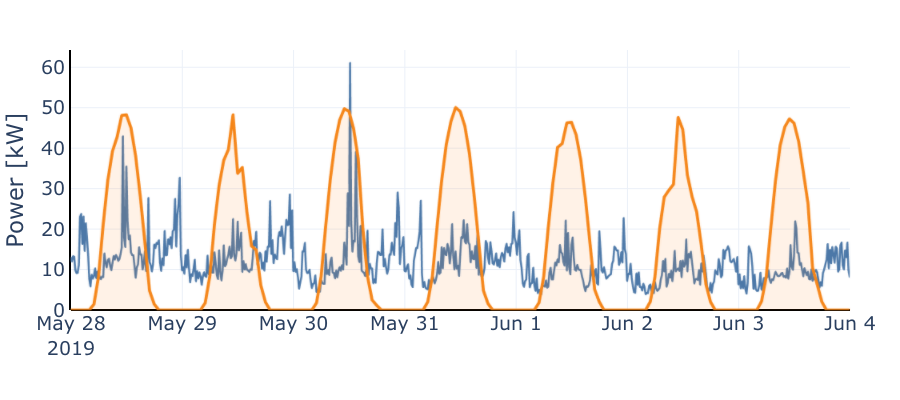

In [22]:
graph = df.loc[start:end, :].copy()
graph.pv_1kw *= nb_houses * 3

fig = px.line(graph, y=["community_kW", "pv_1kw"])
fig.data[1].update(fill="tozeroy", line_width=3,
                   fillcolor="rgba(255, 127, 14, 0.1)")
fig.update_layout(
    layout,
    height=400,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Power [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black')
fig.show(renderer="png")

In [12]:
fig.write_image("results/week_may_june.svg")

# Define boundaries for storage experiment

In [23]:
# TEST
graph = df.copy()
print(f"Values in MWh for {nb_houses} houses")
df[["community_kW", "pv_1kw"]].groupby(pd.Grouper(freq="365D")).sum() * 15 / 60 / 1000

Values in MWh for 20 houses


,community_kW,pv_1kw
Index,,
2019-01-01,111.1246,1.367925


In [24]:
individuals.columns

Index(['2000989', '2001197', '2000914', '2001123', '2000964', '2001189',
       '2001111', '2001179', '2000909', '2000918', '2000994', '2001107',
       '2000913', '2001139', '2000960', '2001149', '2001165', '2000954',
       '2001114', '2000926', 'pv_1kw'],
      dtype='object')

In [25]:
def community_bill(df, member_ids, prod_col, timing, deltat=15, buy_price=0.1740, exchange_price=0.0371):
    """Return cost for the community
    cost = buy [€/kWh] imports + pay fees on exchanges [€]
    """
    # Community import (sum then max)
    pos_netload = (
        (
            df[[a for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
            - df[[prod_col for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
        )
        .clip(lower=0)
        .sum()
        * deltat
        / 60
    )

    # Sum of ind import (max then sum)
    pos_n_netload = (
        sum(
            (df[a] - df[prod_col]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            for a in member_ids
        )
        * deltat
        / 60
    )

    return np.round(
        buy_price * pos_netload + exchange_price * (pos_n_netload - pos_netload), 3
    )

In [26]:
pv_size = 3
values = {}
max_exchange_price = 0.1740
exchange_prices = list(np.linspace(0, max_exchange_price, 100))

graph = individuals.copy()
graph.pv_1kw *= pv_size

for timing in ["15T", "365D"]:
    values[timing] = []
    for exchange_price in exchange_prices:
        resultat = community_bill(graph, house_ids, prod_col="pv_1kw",
                                  timing=timing, exchange_price=exchange_price)
        values[timing].append(resultat)

graph = pd.DataFrame(index=exchange_prices, data=values)
graph.columns = ["No storage", "Theoretical limit"]

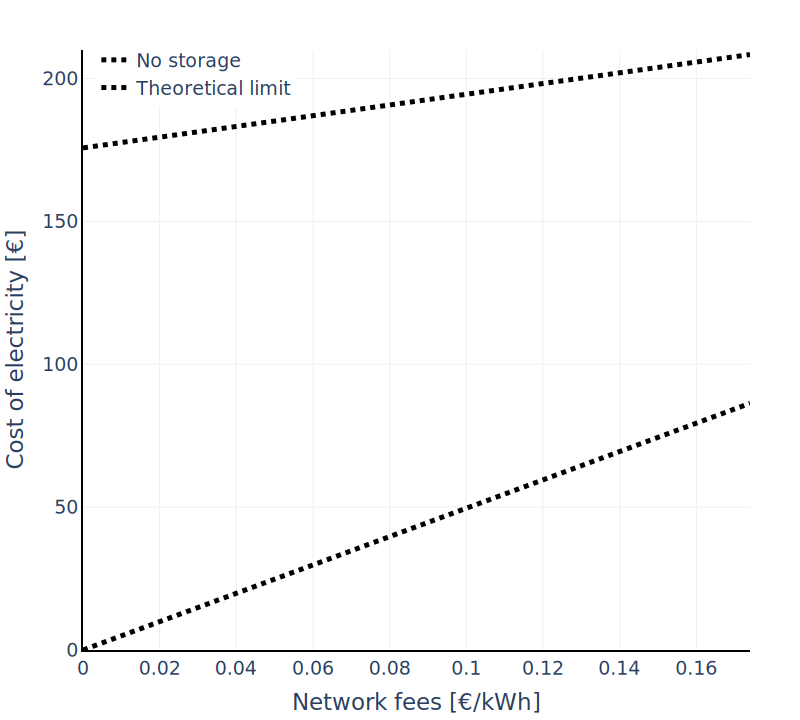

In [27]:
_fig = px.line(graph)
_fig.update_traces(line_width=5, line_dash='dot', line_color="black")

_fig.update_layout(
    layout,
    height=720,
    width=800,
    yaxis_title="Cost of electricity [€]",
    #yaxis_dtick=10,
    xaxis_title="Network fees [€/kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=True, xaxis_linewidth=2, xaxis_linecolor='black',
    #xaxis_range=[0, x_limit],
    yaxis_range=[0, 210],
    showlegend=True,
    legend={"x": 0.02, "y": 1.015},
    legend_title="")
_fig.show()

# Code algorithm 1

In [28]:
df.head()

,pv_1kw,community_kW
Index,,
2019-01-01 00:00:00,0.0,12.930472
2019-01-01 00:15:00,0.0,15.765637
2019-01-01 00:30:00,0.0,12.099126
2019-01-01 00:45:00,0.0,14.475988
2019-01-01 01:00:00,0.0,10.696315


In [29]:
def def1_self_production(df, cons_col, prod_col, storage):
    """
    Defintion 1: Merge storage in production.
    """
    result = {}
    _df = df.copy()
    _df["prod_before_storage"] = _df[prod_col]
    _df[prod_col] = _df[prod_col] - _df[storage]
    
    local = _df[[cons_col, prod_col]].min(axis=1).sum()  # unit do not matter 
    result[f"self_prod"] = local * 100 / _df[cons_col].sum()
    result[f"self_cons"] = local * 100 / _df["prod_before_storage"].sum()
    return result

In [30]:
def best_course_action(cons, prod):
    in_kw = prod - cons
    return in_kw

def battery_constraints(in_kw, soc_kwh, spec, deltat=15):
    # Energy
    offset = spec["max_kwh"] * spec["offset"]
    max_charg_kW = max(
        0, (spec["max_kwh"] - offset - soc_kwh) / (spec["eta"] * deltat / 60)
    )
    if in_kw > max_charg_kW:
        in_kw = max_charg_kW

    max_discharg_kW = min(0, (0 + offset - soc_kwh) * spec["eta"] / (deltat / 60))
    if in_kw < max_discharg_kW:
        in_kw = max_discharg_kW

    # Power
    if in_kw > spec["max_kw"]:
        in_kw = spec["max_kw"]

    if in_kw < -spec["min_kw"]:
        in_kw = -spec["min_kw"]
    return in_kw

def update_soc(in_kw, previous_soc_kwh, spec, deltat=15):
    # Power
    assert in_kw <= spec["max_kw"], f"{in_kw} <= {spec['max_kw']}"
    assert in_kw >= -spec["min_kw"], f"{in_kw} >= {-spec['min_kw']}"

    # Energy
    if in_kw > 0:
        _eta = spec["eta"]
    else:
        _eta = 1 / spec["eta"]
    new_soc_kwh = previous_soc_kwh + _eta * in_kw * deltat / 60
    assert new_soc_kwh <= spec["max_kwh"], f"{new_soc_kwh}"
    assert new_soc_kwh >= 0, f"{new_soc_kwh}"
    return new_soc_kwh

def individual_storage_control(df, cons_col, prod_col, storage_col, soc_col, spec):
    in_kws = [0]
    soc_kwhs = [spec["max_kwh"] * spec["offset"]]
    
    for cons, prod in zip(df[cons_col], df[prod_col]):
        in_kw = best_course_action(cons, prod)
        in_kw = battery_constraints(in_kw, soc_kwhs[-1], spec)
        in_kws.append(in_kw)
        soc_kwhs.append(update_soc(in_kw, soc_kwhs[-1], spec))
    
    del in_kws[0]    
    del soc_kwhs[0]
    df[storage_col] = in_kws
    df[soc_col] = soc_kwhs
    return df

In [31]:
pv_size = 3
battery_size = 3
spec = {"min_kw": nb_houses * battery_size / 2,
        "max_kw": nb_houses * battery_size / 2,
        "max_kwh": nb_houses * battery_size,
        "eta": 0.95,
        "offset": 0.01}
graph = df.loc[start:end, :].copy()
graph.pv_1kw *= nb_houses * pv_size
graph = individual_storage_control(graph, "community_kW", "pv_1kw", "storage", "soc", spec)
resultat = def1_self_production(graph, cons_col="community_kW", prod_col="pv_1kw", storage="storage")
print(f"self-consumption = {round(resultat['self_cons'], 2)} & self-production = {round(resultat['self_prod'], 2)}")

graph.head()

self-consumption = 54.51 & self-production = 68.88


,pv_1kw,community_kW,storage,soc
Index,,,,
2019-05-28 00:00:00,0.0,12.908581,0.0,0.6
2019-05-28 00:15:00,0.0,12.018203,0.0,0.6
2019-05-28 00:30:00,0.0,13.313439,0.0,0.6
2019-05-28 00:45:00,0.0,13.152454,0.0,0.6
2019-05-28 01:00:00,0.0,9.872259,0.0,0.6


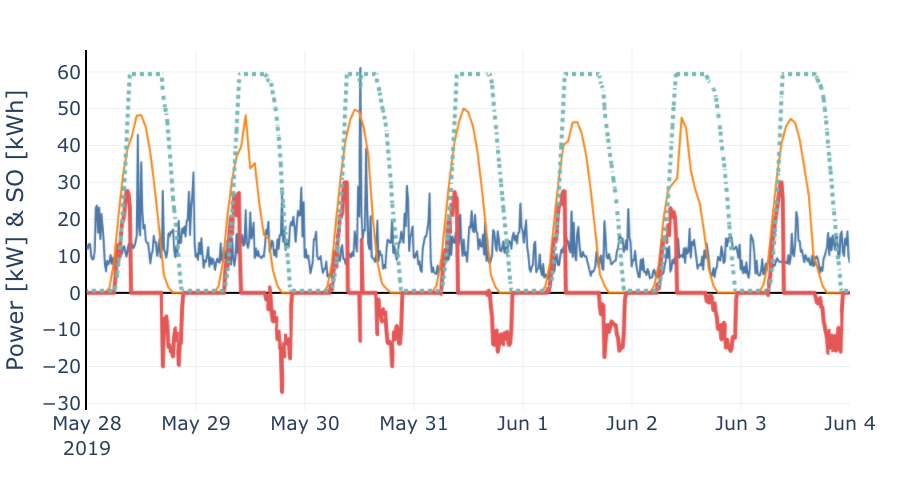

In [33]:
fig = px.line(graph.loc[start:end, :],
              y=["community_kW", "pv_1kw", "storage", "soc"])
fig.data[2].update(line_width=4)
fig.data[3].update(line_width=4, line_dash="dot")
fig.update_layout(
    layout,
    height=500,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Power [kW] & SO [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show(renderer="png")

# Electricity cost for the community of individuals

In [34]:
individuals.columns

Index(['2000989', '2001197', '2000914', '2001123', '2000964', '2001189',
       '2001111', '2001179', '2000909', '2000918', '2000994', '2001107',
       '2000913', '2001139', '2000960', '2001149', '2001165', '2000954',
       '2001114', '2000926', 'pv_1kw'],
      dtype='object')

In [35]:
pv_size = 3
values = []
battery_size = 5
spec = {"min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "eta": 0.95,
        "offset": 0.01}

graph = individuals.copy()
graph.pv_1kw *= pv_size

for house_id in house_ids:
    graph = individual_storage_control(graph, house_id, "pv_1kw", house_id + "_storage", house_id + "_soc", spec)
    graph[house_id] += graph[house_id + "_storage" ]
    
exchange_prices = list(np.linspace(0, max_exchange_price, 100))
for exchange_price in exchange_prices:
    resultat = community_bill(graph, house_ids, prod_col="pv_1kw", timing="15T", exchange_price=exchange_price)
    values.append(resultat)

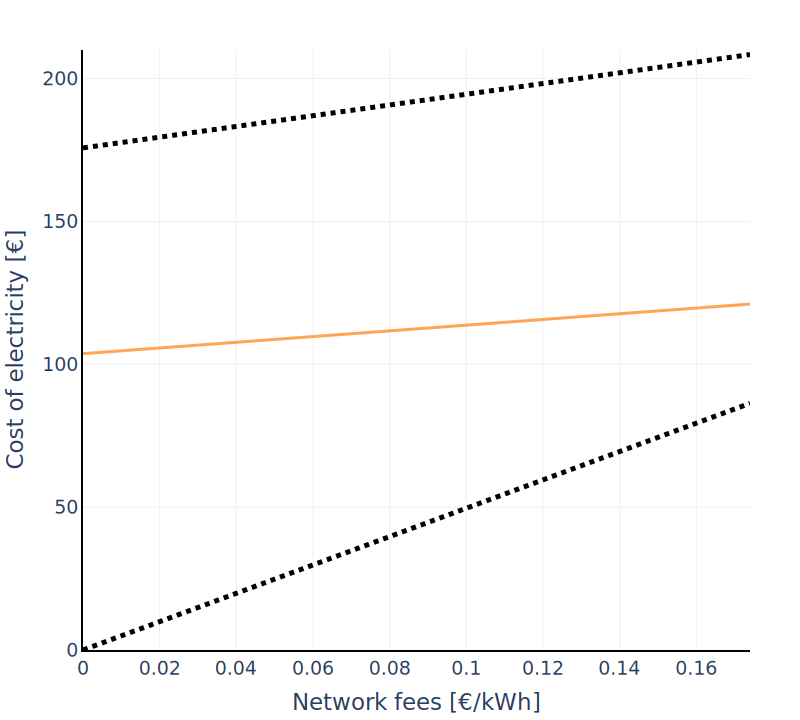

In [36]:
import plotly.graph_objects as go
__fig = go.Figure(_fig)
#fig.update_traces(line_color="black")

graph = pd.DataFrame(index=exchange_prices, data=values)
graph.columns = ["Individuals 100% with 3kWh"]
for trace in px.line(graph).data:
    __fig.add_trace(trace)
    __fig.data[-1].update(line_width=3, line_color="rgba(255, 127, 14, 0.7)")
    __fig.layout.update(showlegend=False)
__fig.show()

# Set optimization algorithm

In [37]:
individuals.columns

Index(['2000989', '2001197', '2000914', '2001123', '2000964', '2001189',
       '2001111', '2001179', '2000909', '2000918', '2000994', '2001107',
       '2000913', '2001139', '2000960', '2001149', '2001165', '2000954',
       '2001114', '2000926', 'pv_1kw'],
      dtype='object')

In [38]:
from pyomo.opt import SolverFactory
from pyomo.environ import *
from dataclasses import dataclass
from datetime import timedelta


@dataclass
class OptimizeBatteries:
    grid_buy: float
    grid_fee: float
    battery_aging_cost: float = 0.0
    only_return_schedules: bool = True
    freq: int = 15
    optim_horizon: timedelta = timedelta(days=2)
    solver: str = "glpk"
    solver_path: str = None
    verbose: bool = False
    
    def _solve(self, netloads, members, assets):
        m = ConcreteModel()
        batteries = assets["batt"]

        m.horizon = Set(initialize=list(netloads.keys()), ordered=True)
        m.members = Set(initialize=list(members.keys()), ordered=True)
        m.batteries = Set(initialize=list(batteries.keys()), ordered=True)

        m.community_import = Var(m.horizon, domain=NonNegativeReals)
        m.member_import = Var(m.horizon, m.members, domain=NonNegativeReals)
        m.batteryin = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryout = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryenergy = Var(m.horizon, m.batteries, domain=NonNegativeReals)

        m.grid_buy = Param(initialize=self.grid_buy)
        m.grid_fee = Param(initialize=self.grid_fee)
        m.battery_aging_cost = Param(initialize=self.battery_aging_cost)
        m.deltat = Param(initialize=self.freq / 60)
        m.last = Param(initialize=m.horizon.last())

        # Battery constraints
        def r_battery_max_powerin(m, t, b):
            return m.batteryin[t, b] <= batteries[b]["max_kw"]

        def r_battery_max_powerout(m, t, b):
            return m.batteryout[t, b] <= batteries[b]["min_kw"]

        def r_battery_energy(m, t, b):
            if t == 0:
                return m.batteryenergy[t, b] == batteries[b]["init_kwh"]
            else:
                return (
                    m.batteryenergy[t, b]
                    == m.batteryenergy[t - 1, b]
                    + m.batteryin[t - 1, b] * m.deltat * batteries[b]["eta"]
                    - m.batteryout[t - 1, b] * m.deltat / batteries[b]["eta"]
                )

        def r_battery_min_energy(m, t, b):
            return (
                m.batteryenergy[t, b]
                >= batteries[b]["max_kwh"] * batteries[b]["offset"]
            )

        def r_battery_max_energy(m, t, b):
            return m.batteryenergy[t, b] <= batteries[b]["max_kwh"] * (
                1 - batteries[b]["offset"]
            )

        def r_battery_end_energy(m, b):
            return m.batteryenergy[m.last, b] >= batteries[b]["end_kwh"]

        def r_battery_end_power_out(m, b):
            return m.batteryout[m.last, b] == 0.0

        def r_battery_end_power_in(m, b):
            return m.batteryin[m.last, b] == 0.0

        # Energy balance
        def r_community_import(m, t):
            return m.community_import[t] >= sum(
                m.batteryin[t, b] - m.batteryout[t, b] for b in m.batteries
            ) + sum(netloads[t][p] for p in m.members)

        def r_member_import(m, t, p):
            return (
                m.member_import[t, p]
                >= sum(
                    m.batteryin[t, b] - m.batteryout[t, b] for b in members[p]["batt"]
                )
                + netloads[t][p]
            )

        m.r1 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerin)
        m.r2 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerout)
        m.r3 = Constraint(m.horizon, m.batteries, rule=r_battery_energy)
        m.r4 = Constraint(m.horizon, m.batteries, rule=r_battery_min_energy)
        m.r5 = Constraint(m.horizon, m.batteries, rule=r_battery_max_energy)
        m.r6 = Constraint(m.batteries, rule=r_battery_end_energy)
        m.r7 = Constraint(m.batteries, rule=r_battery_end_power_out)
        m.r8 = Constraint(m.batteries, rule=r_battery_end_power_in)
        m.r9 = Constraint(m.horizon, rule=r_community_import)
        m.r10 = Constraint(m.horizon, m.members, rule=r_member_import)

        def objective_function(m):
            return sum(
                m.grid_buy * m.community_import[i]
                + m.grid_fee
                * (
                    sum(m.member_import[i, p] for p in m.members)
                    - m.community_import[i]
                )
                + m.battery_aging_cost * sum(m.batteryin[i, b] for b in m.batteries)
                for i in m.horizon
            )

        m.objective = Objective(rule=objective_function, sense=minimize)

        with SolverFactory(self.solver, executable=self.solver_path) as opt:
            results = opt.solve(m, tee=False)
            if self.verbose:
                print(results)
        return m
   
    def solve(self, df, member_ids, prod_col, spec):
        netloads = df.copy()
        for member_id in member_ids:
            netloads[member_id] -= df[prod_col]
        netloads.drop([prod_col], axis=1, inplace=True)
        netloads.index = range(0, len(netloads))
        netloads = netloads.T.to_dict()
        
        members = {member_id:{"batt": [int(i)]} for i, member_id in enumerate(member_ids)}
        
        assets = {}
        assets["batt"] = {i:{
            "min_kw": spec["min_kw"],
            "max_kw": spec["max_kw"],
            "max_kwh": spec["max_kwh"],
            "eta": spec["eta"],
            "offset": spec["offset"],
            "init_kwh": spec["max_kwh"] * spec["offset"],
            "end_kwh": spec["max_kwh"] * spec["offset"]
        } for i, member_id in enumerate(member_ids)}

        model = self._solve(netloads, members, assets)
        return self.postprocess(model, df, member_ids)

    def postprocess(self, model, predictions, member_ids):
        schedules = get_timevar_from_pyomo(model, predictions.index)
        schedules["schedules"] = (
            schedules["batteryin"] - schedules["batteryout"]
        ).copy()

        if self.only_return_schedules:
            schedules = schedules["schedules"]
            schedules.columns = member_ids
        return schedules

def get_timevar_from_pyomo(model, timeindex):
    results = {}
    for var in model.component_objects(Var):
        if var.index_set()._implicit_subsets is None:
            results[var.name] = pd.DataFrame(
                index=[var.name], data=getattr(model, var.name).get_values()
            ).transpose()
            results[var.name].index = timeindex
        else:
            results[var.name] = (
                pd.DataFrame(index=["none"], data=getattr(model, var.name).get_values())
                .transpose()
                .unstack(level=1)
            )
            results[var.name].columns = results[var.name].columns.levels[1]
            results[var.name].index = timeindex
    return results

In [39]:
pv_size = 3
battery_size = 5
spec = {"min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "eta": 0.95,
        "offset": 0.01}

graph = individuals.copy()
graph.pv_1kw *= pv_size

model = OptimizeBatteries(grid_buy=0.1740, grid_fee=0.0371,
                          verbose=True, only_return_schedules=False)

schedule = model.solve(graph, house_ids, "pv_1kw", spec)


Problem: 
- Name: unknown
  Lower bound: 306.705810930713
  Upper bound: 306.705810930713
  Number of objectives: 1
  Number of constraints: 81494
  Number of variables: 54514
  Number of nonzeros: 175654
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 26.761863946914673
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



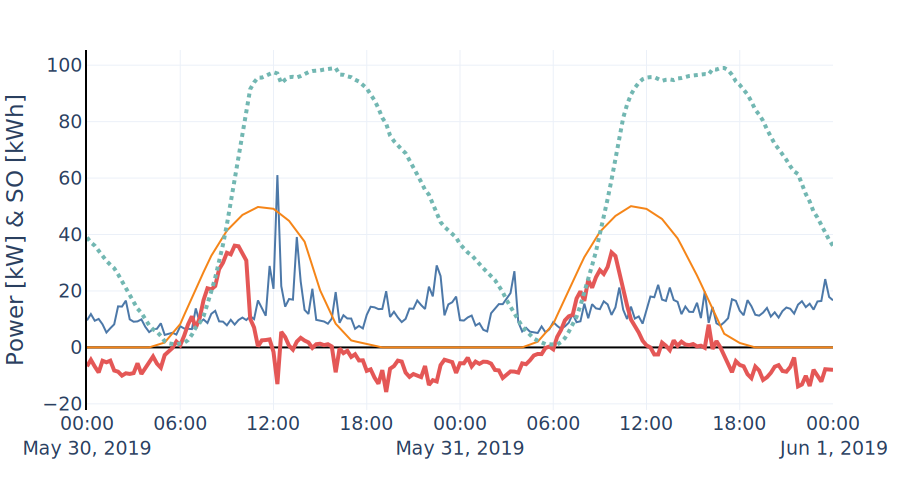

In [40]:
graph = individuals.copy()
graph["community_kW"] = graph[house_ids].sum(axis=1)
graph.drop(house_ids, axis=1, inplace=True)

graph.pv_1kw *= nb_houses * pv_size

graph["storage"] = schedule["schedules"].sum(axis=1)
graph["soc"] = schedule["batteryenergy"].sum(axis=1)


fig = px.line(graph.loc[start+timedelta(days=2):end-timedelta(days=3), :],
              y=["community_kW", "pv_1kw", "storage", "soc"])

fig.data[2].update(line_width=4)
fig.data[3].update(line_width=4, line_dash="dot")
fig.update_layout(
    layout,
    height=500,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Power [kW] & SO [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()

In [35]:
fig.write_image("results/optimization.svg")

# Electricity cost for the optimized community

In [41]:
individuals.columns

Index(['2000989', '2001197', '2000914', '2001123', '2000964', '2001189',
       '2001111', '2001179', '2000909', '2000918', '2000994', '2001107',
       '2000913', '2001139', '2000960', '2001149', '2001165', '2000954',
       '2001114', '2000926', 'pv_1kw'],
      dtype='object')

In [42]:
values = []
pv_size = 3
battery_size = 5
spec = {"min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "eta": 0.95,
        "offset": 0.01}

exchange_prices = list(np.linspace(0, max_exchange_price, 30))
for exchange_price in exchange_prices:
    
    # To avoid infinite optimization problem
    if exchange_price >= 0.1740:
        exchange_price_bis = 0.1740
    else:
        exchange_price_bis = exchange_price
    
    graph = individuals.copy()
    graph.pv_1kw *= pv_size
    
    model = OptimizeBatteries(grid_buy=0.1740, grid_fee=exchange_price_bis)
    schedule = model.solve(graph, house_ids, "pv_1kw", spec)
    
    for house_id in house_ids:
        graph[house_id] += schedule[house_id]
    
    resultat = community_bill(graph, house_ids, prod_col="pv_1kw", timing="15T", exchange_price=exchange_price)
    values.append(resultat)

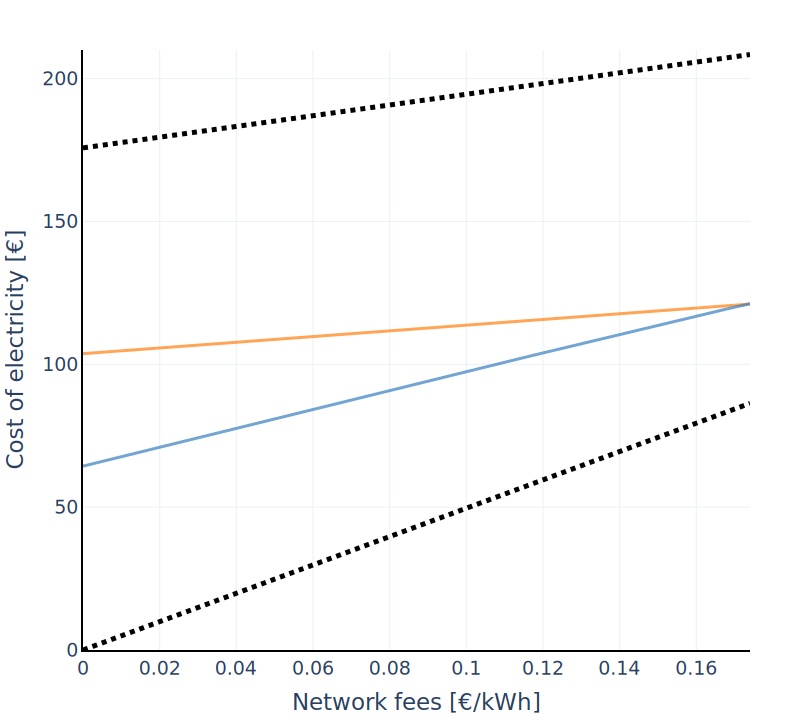

In [43]:
import plotly.graph_objects as go
___fig = go.Figure(__fig)
#fig.update_traces(line_color="black")

graph = pd.DataFrame(index=exchange_prices, data=values)
graph.columns = ["Collaborative coalition"]
for trace in px.line(graph).data:
    ___fig.add_trace(trace)
    ___fig.data[-1].update(line_width=3, line_color="rgba(55, 128, 191, 0.7)")
    ___fig.layout.update(showlegend=False)
___fig.show()

In [33]:
___fig.write_image("results/euros_coalition_value.svg")

In [38]:
107.409 - 76.311

31.098